# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:

from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

import numpy as np
import matplotlib.pyplot as plt

Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

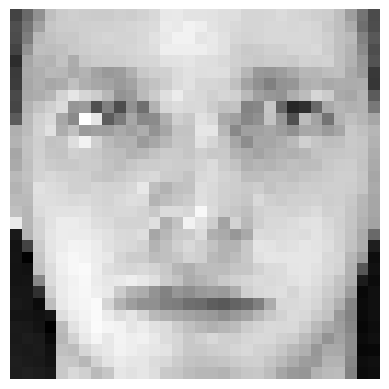

In [3]:
# Display a single example.
show_single_face(data[0, :])

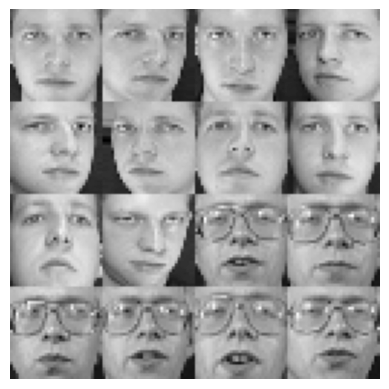

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [43]:
import numpy as np

def l2_rls_train(data, labels, lmbd):
    """
    Trains a linear model using L2-regularized least squares.
    
    data: np.array of shape (n_samples, n_features)
        The input data.
    labels: np.array of shape (n_samples, n_outputs)
        The target values.
    lmbd: float
        The regularization parameter lambda.
        
    Returns: np.array of shape (n_features+1, n_outputs)
        The model parameters, including the bias term.
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones for the bias term.
    X_tilde = np.hstack((X, np.ones((X.shape[0], 1))))
    
    # When lambda is zero, use the pseudo-inverse.
    if lmbd == 0:
        w = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ y
    else:
        # Compute the coefficient vector with L2 regularization.
        w = np.linalg.inv(X_tilde.T @ X_tilde + lmbd * np.eye(X_tilde.shape[1])) @ X_tilde.T @ y
    
    # Return model parameters.
    return w


Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [44]:
def l2_rls_predict(w, data):
    """
    Predicts the output for the given data using the trained L2-regularized least squares model.
    
    data: np.array of shape (n_samples, n_features)
        The input data.
    w: np.array of shape (n_features+1, n_outputs)
        The model parameters, including the bias term.
        
    Returns: np.array of shape (n_samples, n_outputs)
        The predicted output values.
    """
    
    # Expand the data with a column of ones for the bias term.
    X_tilde = np.hstack((data, np.ones((data.shape[0], 1))))
    
    # Compute the prediction.
    predicted_y = X_tilde @ w
        
    return predicted_y


### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

# Load your data and labels
data, labels = load_data()

# Normalize the data
data = data / 255

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, test_size=0.5, random_state=42)

# One-hot encoding of the labels
num_classes = len(np.unique(labels))
y_train_one_hot = np.eye(num_classes)[(y_train - 1).reshape(-1)]

# Hyperparameter selection using k-fold cross-validation
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
k = 5
kf = KFold(n_splits=k)

best_lambda = None
best_accuracy = 0

for lmbd in lambdas:
    accuracies = []
    
    for train_indices, val_indices in kf.split(X_train):
        X_train_fold, y_train_fold = X_train[train_indices], y_train_one_hot[train_indices]
        X_val_fold, y_val_fold = X_train[val_indices], y_train[val_indices]
        
        w = l2_rls_train(X_train_fold, y_train_fold, lmbd)
        y_val_pred = l2_rls_predict(w, X_val_fold)
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        
        accuracy = np.mean(y_val_pred_labels == (y_val_fold - 1))
        accuracies.append(accuracy)
        
    mean_accuracy = np.mean(accuracies)
    
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_lambda = lmbd

# Train the final model with the selected lambda
w_final = l2_rls_train(X_train, y_train_one_hot, best_lambda)

# Evaluate the model on the test set
y_test_pred = l2_rls_predict(w_final, X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

print("Selected lambda:", best_lambda)
print("Confusion matrix:\n", conf_matrix)


Selected lambda: 0.0001
Confusion matrix:
 [[0 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [1 4 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]]


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Subject 16:
Subject 9:
Subject 38:
Subject 20:
Subject 0:


C:\Users\asadk\AppData\Local\Temp\ipykernel_13548\1627510501.py:14: RuntimeWarning: invalid value encountered in divide
  accuracy_per_subject = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
c:\Users\asadk\Documents\Machine Learning\Lab 2\lab3lib.py:51: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(img_grid, cmap='gray')


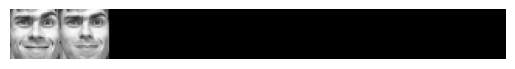

In [46]:
from sklearn.metrics import confusion_matrix

# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

# Convert continuous predictions to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Calculate classification accuracy for each subject
accuracy_per_subject = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Find the top k subjects with the highest classification accuracy
k = 5
top_k_subjects = np.argsort(accuracy_per_subject)[-k:]

# Print the test images of the top k subjects
for subject in top_k_subjects:
    subject_test_indices = np.where((y_test == subject) & (y_test_pred_labels == subject))[0]
    subject_test_images = X_test[subject_test_indices]

    print(f"Subject {subject}:")
    show_faces(subject_test_images)


 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

Subject 40:
Subject 21:
Subject 22:
Subject 23:
Subject 24:


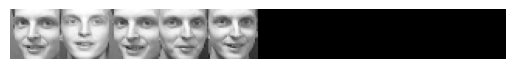

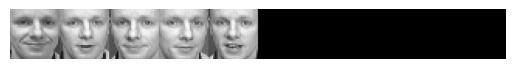

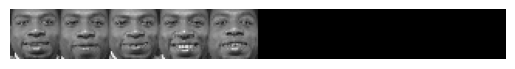

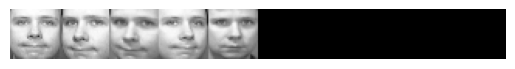

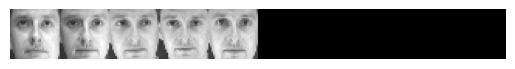

In [47]:
# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

# Convert y_test_pred to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Find the bottom k subjects with the lowest classification accuracy
k = 5
bottom_k_subjects = np.argsort(accuracy_per_subject)[:k]

# Print the misclassified test images of the bottom k subjects
for subject in bottom_k_subjects:
    subject_test_indices = np.where((y_test == subject) & (y_test_pred_labels != subject))[0]
    subject_test_images = X_test[subject_test_indices]

    print(f"Subject {subject}:")
    show_faces(subject_test_images)



### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [48]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

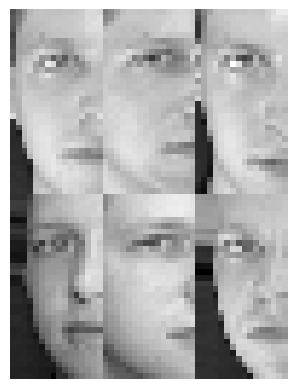

In [49]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

Mean Absolute Percentage Error (MAPE): 0.27


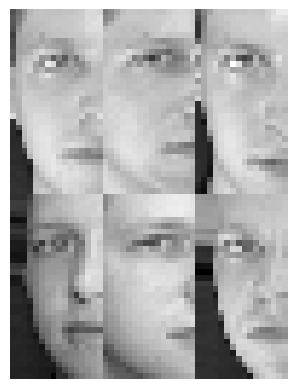

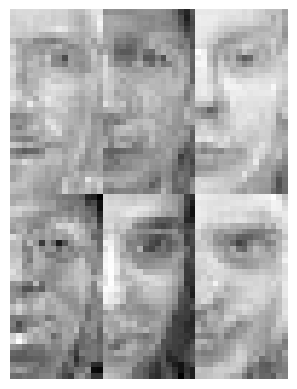

In [50]:
# Your code goes here

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

# Normalize the data
data = data / 255

# Split the data into left and right faces
left, right = split_left_right(data)

# Visualize the left faces
show_split_faces(left[:6, :], num_per_row=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(left, right, test_size=0.3, random_state=42)

# Train the L2-RLS model with lambda = 0
lmbd = 0
w = l2_rls_train(X_train, y_train, lmbd)

# Make predictions on the test set
y_pred = l2_rls_predict(w, X_test)

# Calculate the mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

# Visualize the predicted right faces
show_split_faces(y_pred[:6, :], num_per_row=3)


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

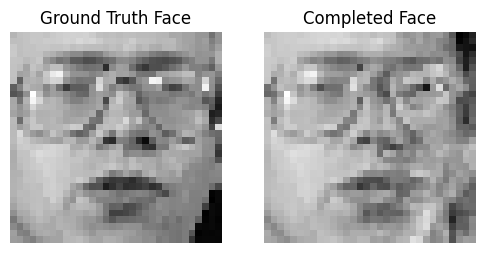

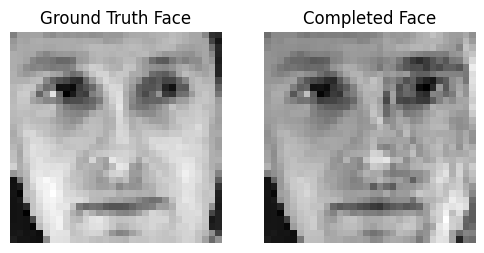

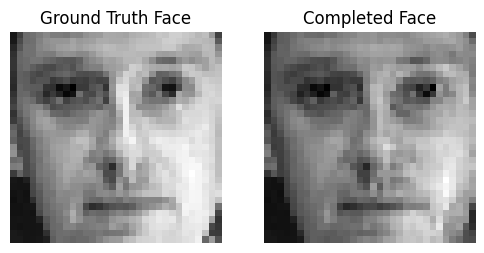

In [51]:
# Your code goes here

import random

def join_left_right(left, right, h=32, w=16):
    joined = np.concatenate((left.reshape(h, w),
                             right.reshape(h, w)),
                            axis=1).reshape(-1)
    return joined

def visualize_faces_comparison(left, true_right, predicted_right, num_samples=3):
    random_indices = random.sample(range(left.shape[0]), num_samples)

    for idx in random_indices:
        true_face = join_left_right(left[idx], true_right[idx], h=32, w=16)
        completed_face = join_left_right(left[idx], predicted_right[idx], h=32, w=16)

        plt.figure(figsize=(6, 3))

        plt.subplot(1, 2, 1)
        plt.imshow(true_face.reshape(32, 32), cmap='gray')
        plt.title("Ground Truth Face")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(completed_face.reshape(32, 32), cmap='gray')
        plt.title("Completed Face")
        plt.axis('off')

        plt.show()

# Normalize the data
data = data / 255

# Split the data into left and right faces
left, right = split_left_right(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(left, right, test_size=0.3, random_state=42)

# Train the L2-RLS model with lambda = 0
lmbd = 0
w = l2_rls_train(X_train, y_train, lmbd)

# Make predictions on the test set
y_pred = l2_rls_predict(w, X_test)

# Visualize the comparison for 3 randomly chosen testing samples
visualize_faces_comparison(X_test, y_test, y_pred, num_samples=3)






### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [67]:
def lls_gd_train(data, labels, N, eta, test_data=None, test_labels=None):
    X, y = data, labels.reshape(-1, 1)
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))

    w = np.zeros((X_tilde.shape[1], 1))

    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros(N)

    train_acc_all = np.zeros(N)
    test_acc_all = np.zeros(N)

    for i in range(N):
        gd = -2 * X_tilde.T @ (y - X_tilde @ w) / X_tilde.shape[0]
        cost = np.sum((y - X_tilde @ w) ** 2)

        w = w - eta * gd

        w_all[i, :] = w.ravel()
        cost_all[i] = cost

        train_pred = np.clip(np.hstack((np.ones((data.shape[0], 1)), data)) @ w, 0, 2).round()
        train_acc = accuracy_score(labels, train_pred)
        train_acc_all[i] = train_acc

        if test_data is not None and test_labels is not None:
            test_pred = np.clip(np.hstack((np.ones((test_data.shape[0], 1)), test_data)) @ w, 0, 2).round()
            test_acc = accuracy_score(test_labels, test_pred)
            test_acc_all[i] = test_acc

    if test_data is not None and test_labels is not None:
        return cost_all, w_all, train_acc_all, test_acc_all
    else:
        return cost_all, w_all



### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

Training accuracy: 0.975
Test accuracy: 0.975


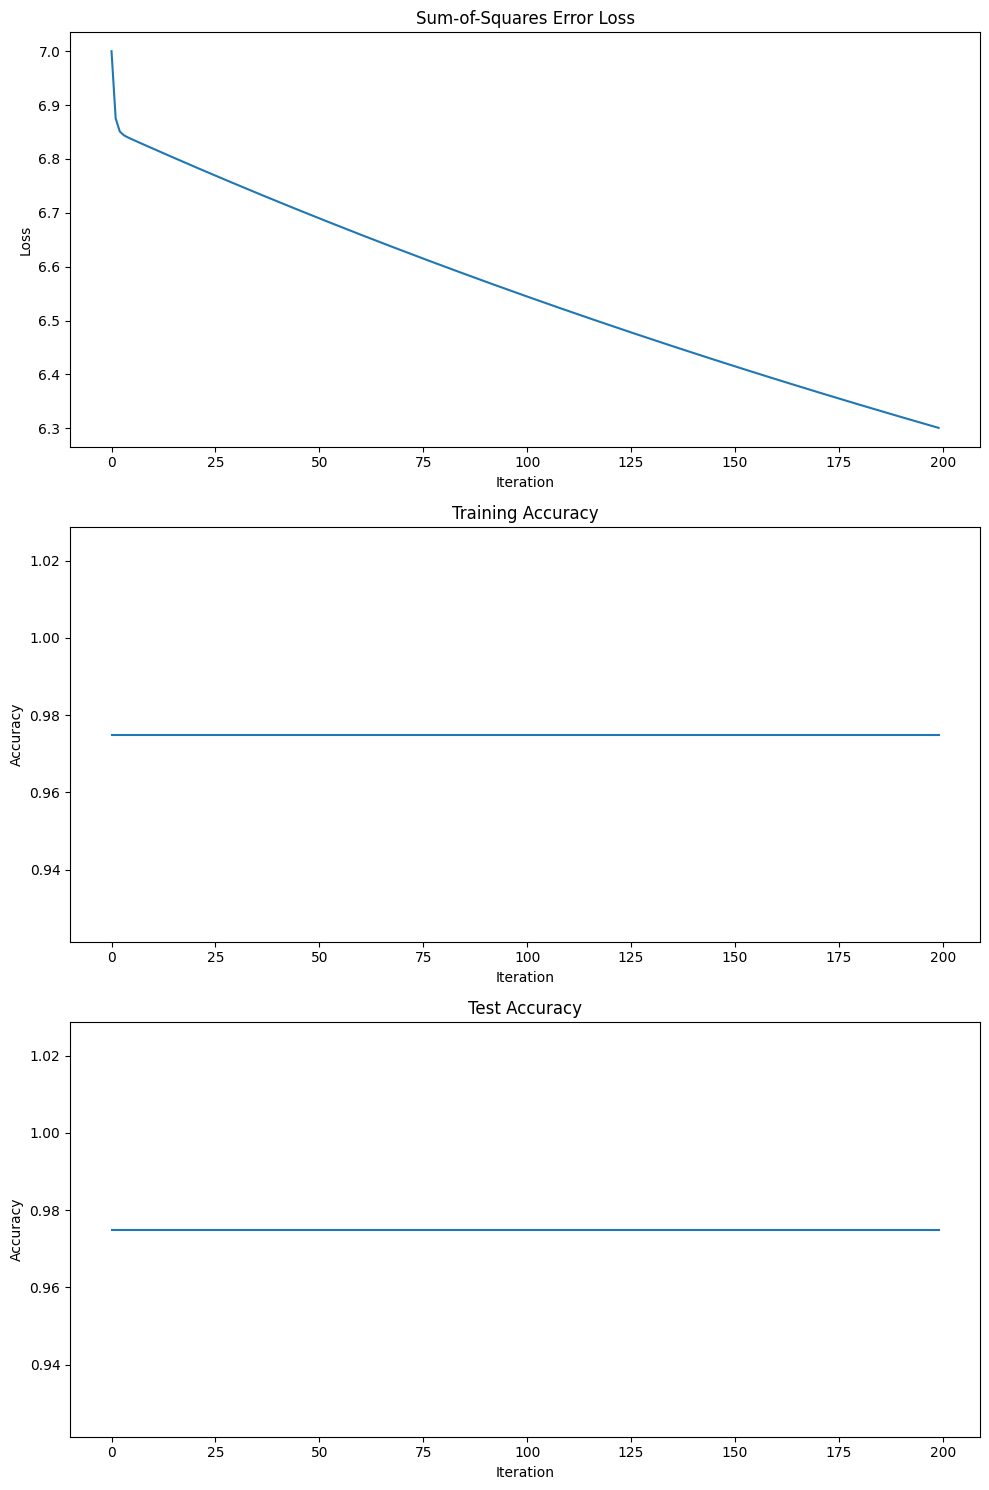

In [76]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

# Load your dataset
data, labels = load_data()

# Split the dataset into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

# Normalize the data
train_data = train_data / 255.0
test_data = test_data / 255.0

# Modify labels for binary classification
binary_train_labels = np.where(train_labels == 30, 1, 0)
binary_test_labels = np.where(test_labels == 30, 1, 0)

# Define the range of hyperparameters to search
learning_rates = [1e-3]
iterations = [200]

best_train_accuracy = 0
best_test_accuracy = 0
best_hyperparams = None

# Perform a grid search
for eta in learning_rates:
    for N in iterations:
        cost_all, w_all = lls_gd_train(train_data, binary_train_labels, N, eta)

        # Check for NaN values in the weights
        if np.isnan(w_all).any():
            continue

        # Compute predictions for the train and test sets
        train_pred = np.hstack((np.ones((train_data.shape[0], 1)), train_data)) @ w_all[-1]
        test_pred = np.hstack((np.ones((test_data.shape[0], 1)), test_data)) @ w_all[-1]

        # Check for NaN values in the predictions
        if np.isnan(train_pred).any() or np.isnan(test_pred).any():
            continue

        # Clip the predictions to the valid range [0, 1] and round them to the nearest integer
        train_pred = np.clip(train_pred, 0, 1).round()
        test_pred = np.clip(test_pred, 0, 1).round()

        # Calculate accuracy
        train_accuracy = accuracy_score(binary_train_labels, train_pred)
        test_accuracy = accuracy_score(binary_test_labels, test_pred)

        # Update best hyperparameters if the test accuracy is improved
        if test_accuracy > best_test_accuracy:
            best_train_accuracy = train_accuracy
            best_test_accuracy = test_accuracy
            best_hyperparams = (eta, N)

print("Training accuracy:", best_train_accuracy)
print("Test accuracy:", best_test_accuracy)

cost_all, w_all, train_acc_all, test_acc_all = lls_gd_train(train_data, binary_train_labels, best_hyperparams[1], best_hyperparams[0], test_data, binary_test_labels)

# Plot the change of sum-of-squares error loss, training accuracy, and test accuracy over iterations
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].plot(cost_all)
ax[0].set_title("Sum-of-Squares Error Loss")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")

ax[1].plot(train_acc_all)
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")

ax[2].plot(test_acc_all)
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()




Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

Learning rate (eta): 0.01
Number of iterations: 200
Training accuracy: 0.975
Test accuracy: 0.975


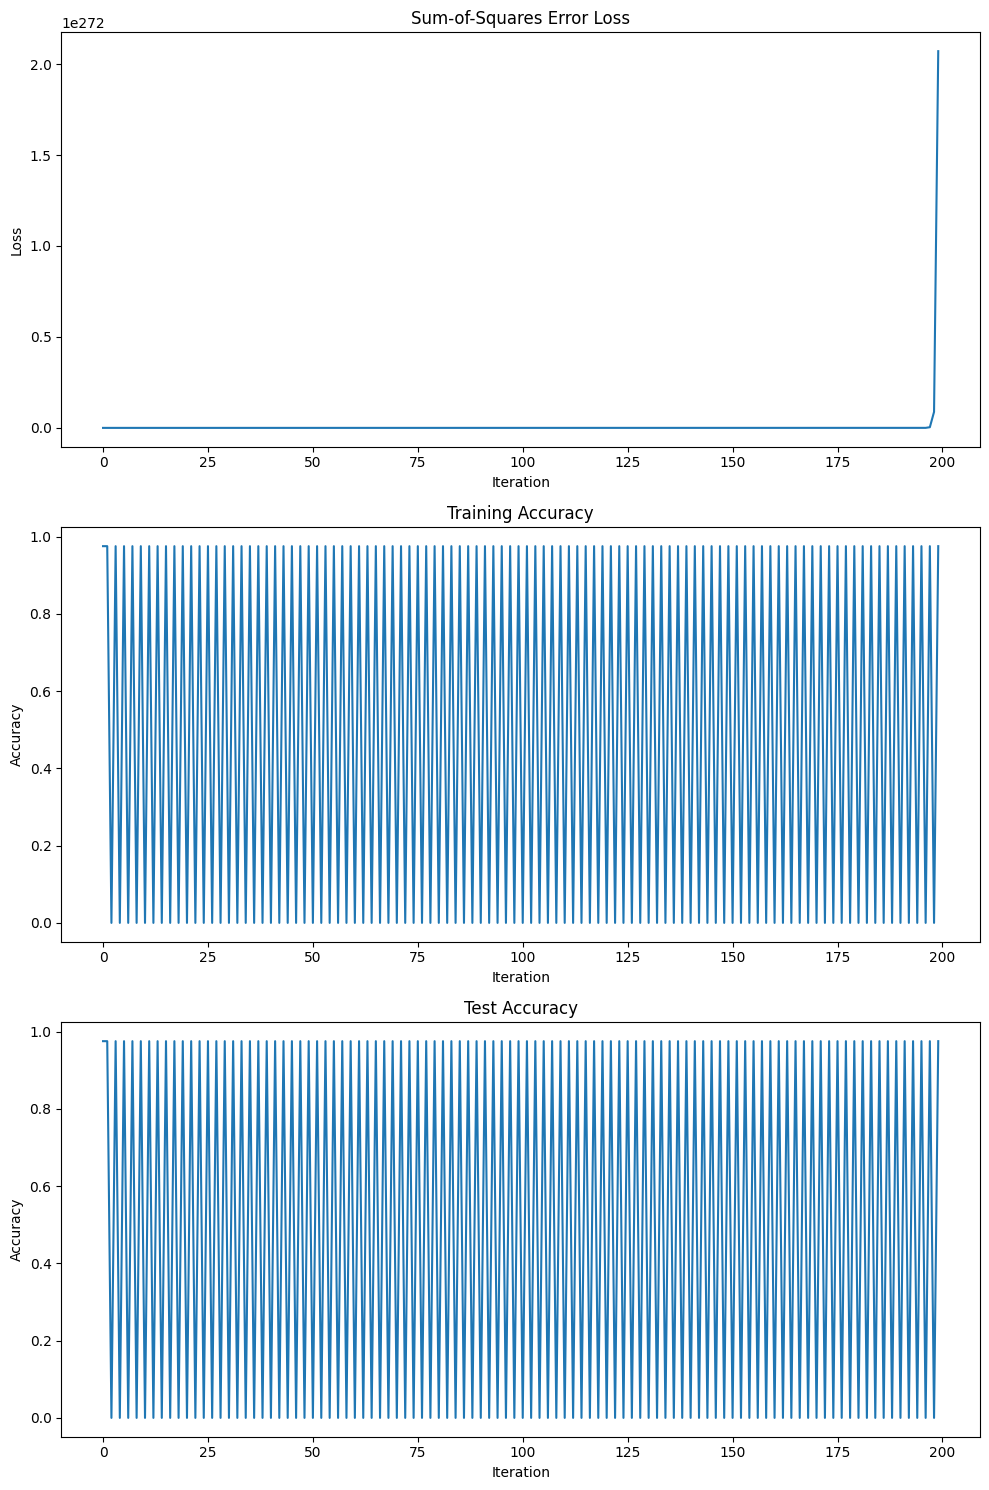

In [74]:
# Modify labels for binary classification
binary_train_labels = np.where(train_labels == 30, 1, 0)
binary_test_labels = np.where(test_labels == 30, 1, 0)

eta = 1e-2
N = 200

cost_all, w_all, train_acc_all, test_acc_all = lls_gd_train(train_data, binary_train_labels, N, eta, test_data, binary_test_labels)

# Print the learning rate and number of iterations
print("Learning rate (eta):", eta)
print("Number of iterations:", N)

# Print the final training and test accuracy
print("Training accuracy:", train_acc_all[-1])
print("Test accuracy:", test_acc_all[-1])

# Plot the change of sum-of-squares error loss, training accuracy, and test accuracy over iterations
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].plot(cost_all)
ax[0].set_title("Sum-of-Squares Error Loss")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")

ax[1].plot(train_acc_all)
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")

ax[2].plot(test_acc_all)
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()





### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [167]:
# Your code goes here


### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


In [1]:
# Your code goes here


### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [91]:

def hinge_gd_train(data, labels, eta, num_iterations=None, C=1, test_data=None, test_labels=None):
    """
    Trains a single-output linear model by minimizing the hinge loss using the gradient descent approach.

    data: np.array of shape (n_samples, n_features)
        The input data.
    labels: np.array of shape (n_samples,)
        The target values.
    learning_rate: float
        The learning rate for the gradient descent algorithm.
    N: int
        The number of iterations.
    C: float
        The regularization hyperparameter.

    Returns: Tuple (cost_all, w_all)
        cost_all: np.array of shape (N,)
            The hinge loss values for each iteration.
        w_all: np.array of shape (N, n_features+1)
            The model weights at each iteration, including the bias term.
    """
    if num_iterations is None:
        num_iterations = 1000
        
    # Normalize the data
    X = data.copy() / 255
    y = labels.reshape(-1, 1)
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    w = np.zeros((X_tilde.shape[1], 1))
    w_all = np.zeros((num_iterations, X_tilde.shape[1]))
    cost_all = np.zeros(num_iterations)

    if test_data is not None and test_labels is not None:
        test_X = test_data.copy() / 255
        test_X_tilde = np.hstack((np.ones((test_X.shape[0], 1)), test_X))
        test_cost_all = np.zeros(num_iterations)

    for t in range(num_iterations):
        margin = y * (X_tilde @ w)
        gd = -np.mean((margin < 1) * y * X_tilde, axis=0).reshape(-1, 1) + w / C
        w = w - eta * gd
        cost = np.mean(np.maximum(0, 1 - margin)) + np.sum(w ** 2) / (2 * C)
        w_all[t, :] = w.reshape(1, -1)
        cost_all[t] = cost

        if test_data is not None and test_labels is not None:
            test_margin = test_labels.reshape(-1, 1) * (test_X_tilde @ w)
            test_cost = np.mean(np.maximum(0, 1 - test_margin)) + np.sum(w ** 2) / (2 * C)
            test_cost_all[t] = test_cost

    if test_data is not None and test_labels is not None:
        return cost_all, w_all, test_cost_all
    else:
        return cost_all, w_all



### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


Least Squares Loss:
Training accuracy: 0.02
Test accuracy: 0.04
Hinge Loss:
Training accuracy: 0.02
Test accuracy: 0.04


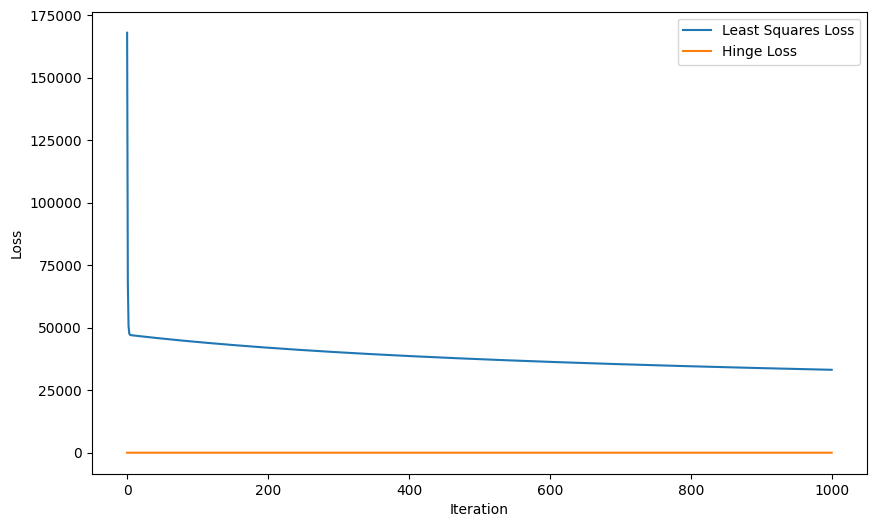

In [97]:
from lab3lib import load_data
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def custom_partition_data(data, labels, test_size=0.25, random_state=42):
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    return train_data, train_labels, test_data, test_labels

# Load the data
data, labels = load_data()
data = data / 255 # Normalize the data by dividing by 255
train_data, train_labels, test_data, test_labels = custom_partition_data(data, labels)

N = 1000
learning_rate = 0.001

# Train the linear classifier using the least squared loss with gradient descent
cost_all_lls, w_all_lls = lls_gd_train(train_data, train_labels, N, learning_rate)

# Calculate the training and test accuracy for the model
train_pred_lls = np.sign(np.hstack((np.ones((train_data.shape[0], 1)), train_data)) @ w_all_lls[-1])
test_pred_lls = np.sign(np.hstack((np.ones((test_data.shape[0], 1)), test_data)) @ w_all_lls[-1])

train_accuracy_lls = accuracy_score(train_labels, train_pred_lls)
test_accuracy_lls = accuracy_score(test_labels, test_pred_lls)

# Train the linear classifier using the hinge loss with gradient descent
C = 1
cost_all_hinge, w_all_hinge, test_cost_all_hinge = hinge_gd_train(train_data, train_labels, learning_rate, N, C, test_data, test_labels)


# Calculate the training and test accuracy for the model
train_pred_hinge = np.sign(np.hstack((np.ones((train_data.shape[0], 1)), train_data)) @ w_all_hinge[-1])
test_pred_hinge = np.sign(np.hstack((np.ones((test_data.shape[0], 1)), test_data)) @ w_all_hinge[-1])

train_accuracy_hinge = accuracy_score(train_labels, train_pred_hinge)
test_accuracy_hinge = accuracy_score(test_labels, test_pred_hinge)

# Print the training and test accuracy for both models
print("Least Squares Loss:")
print("Training accuracy:", train_accuracy_lls)
print("Test accuracy:", test_accuracy_lls)
print("Hinge Loss:")
print("Training accuracy:", train_accuracy_hinge)
print("Test accuracy:", test_accuracy_hinge)

# Plot the cost function values for both models over the iterations
plt.figure(figsize=(10, 6))
plt.plot(cost_all_lls, label='Least Squares Loss')
plt.plot(cost_all_hinge, label='Hinge Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**